/Users/shamit/Documents/Projects/RA/cobas/cobas/venv/lib/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


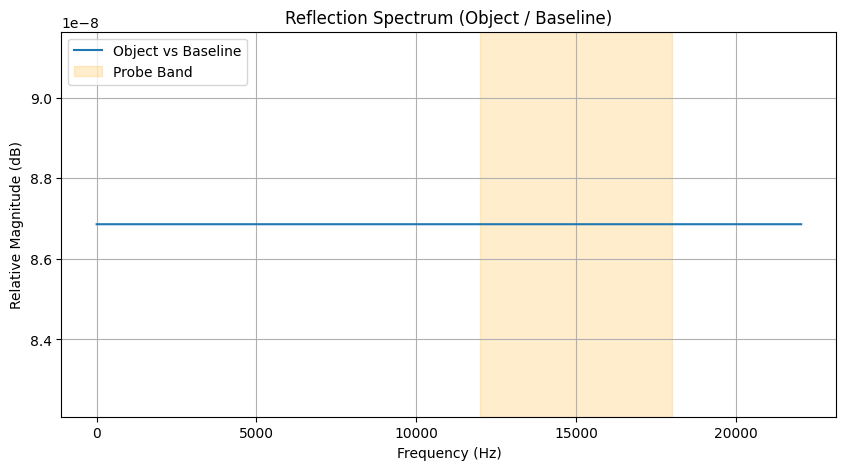

In [ ]:
import os, subprocess
import numpy as np
import matplotlib.pyplot as plt
import torchaudio

# ------------------------------
# SETTINGS
# ------------------------------
SAMPLE_RATE = 44100
NFFT = 2048
HOP = 512

def extract_audio(video_path, out_wav, sr=SAMPLE_RATE):
    """Extract mono audio from .MOV using ffmpeg"""
    cmd = [
        "ffmpeg", "-y", "-i", video_path,
        "-ar", str(sr), "-ac", "1", out_wav
    ]
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)
    return out_wav

def load_audio(path, sr=SAMPLE_RATE):
    """Load audio as numpy"""
    y, sr0 = torchaudio.load(path)
    if sr0 != sr:
        y = torchaudio.functional.resample(y, sr0, sr)
    return y[0].numpy()

def stft_mag(y, nfft=NFFT, hop=HOP):
    """Magnitude spectrum (averaged over frames)"""
    # framing
    frames = np.lib.stride_tricks.sliding_window_view(y, nfft)[::hop]
    window = np.hanning(nfft)
    S = np.fft.rfft(frames * window, axis=-1)
    mag = np.abs(S)
    return mag.mean(axis=0)   # average spectrum

# ------------------------------
# FILE PATHS
# ------------------------------
video_obj = "baseline.MOV"    # object video
video_base = "baseline.MOV"  # baseline video

audio_obj = "battery.wav"
audio_base = "baseline.wav"

# 1. Extract audio from video
extract_audio(video_obj, audio_obj)
extract_audio(video_base, audio_base)

# 2. Load audios
y_obj = load_audio(audio_obj)
y_base = load_audio(audio_base)


# 3. Compute average spectra
obj_avg = stft_mag(y_obj)
base_avg = stft_mag(y_base)

# 4. Reflection signature (ratio)
eps = 1e-8
H = (obj_avg + eps) / (base_avg + eps)
Hdb = 20 * np.log10(H + eps)

# 5. Frequency axis
freqs = np.linspace(0, SAMPLE_RATE/2, len(Hdb))

# 6. Plot
plt.figure(figsize=(10,5))
plt.plot(freqs, Hdb, label="Object vs Baseline")
plt.axvspan(12000, 18000, color="orange", alpha=0.2, label="Probe Band")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Relative Magnitude (dB)")
plt.title("Reflection Spectrum (Object / Baseline)")
plt.legend()
plt.grid(True)
plt.show()


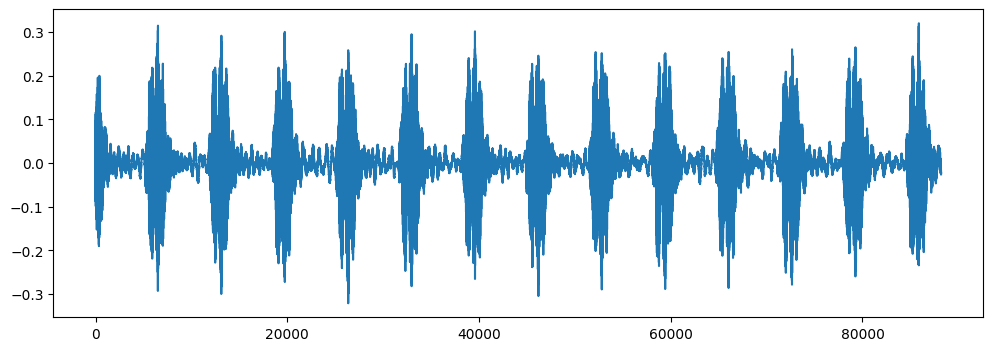

In [6]:
import torch
import torchaudio
import matplotlib.pyplot as plt
waveform, sr = torchaudio.load("./recorded_audio/battery/test/empty_3_seg0.wav")

max_len = 2 * sr

waveform = waveform[:, :max_len]
nf = waveform.shape[1]
tx = torch.arange(0, nf)

plt.figure(figsize=(12,4))

for i in range(waveform.shape[0]):
    plt.plot(tx.numpy(), waveform[i].numpy(), label=f"{i+1}")

plt.show()

# specto = torchaudio.transforms.Spectrogram(
#     n_fft=1024,
#     win_length=None,
#     hop_length=512,
#     power=2.0
# )
# spec = specto(waveform)
# spec_db = torchaudio.transforms.AmplitudeToDB()(spec)

# plt.figure(figsize=(10,6))
# plt.imshow(spec_db.squeeze().numpy(), origin="lower", cmap="inferno")
# plt.show()

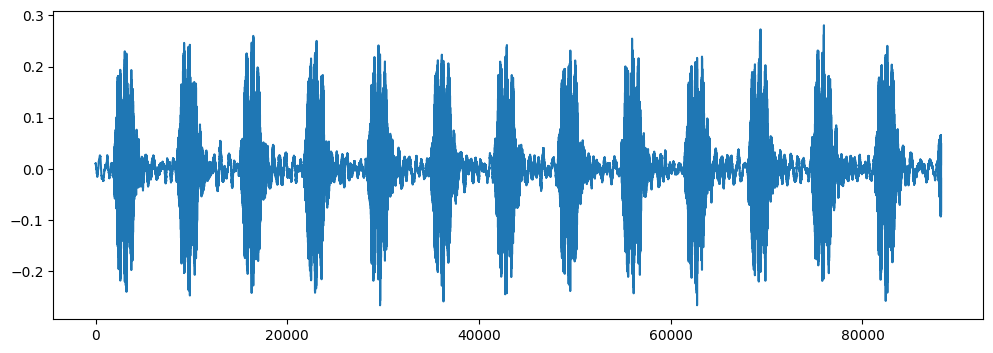

In [5]:
import torch
import torchaudio
import matplotlib.pyplot as plt
waveform, sr = torchaudio.load("baseline.wav")

max_len = 2 * sr

waveform = waveform[:, :max_len]
nf = waveform.shape[1]
tx = torch.arange(0, nf)

plt.figure(figsize=(12,4))

for i in range(waveform.shape[0]):
    plt.plot(tx.numpy(), waveform[i].numpy(), label=f"{i+1}")

plt.show()

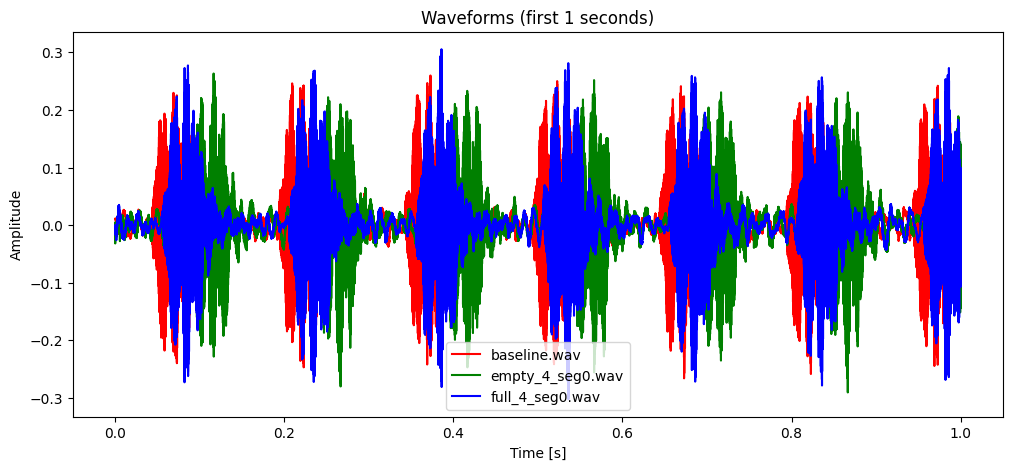

In [10]:
import torch
import torchaudio
import matplotlib.pyplot as plt

files = [
    "./baseline.wav",
    "./recorded_audio/battery/test/empty_4_seg0.wav",
    "./recorded_audio/battery/test/full_4_seg0.wav"
]
colors = ["r", "g", "b"]

plt.figure(figsize=(12, 5))

for i, (file, color) in enumerate(zip(files, colors)):
    # Load waveform
    waveform, sr = torchaudio.load(file)

    # Keep only first 2 seconds
    max_len = 1 * sr
    waveform = waveform[:, :max_len]

    nf = waveform.shape[1]
    tx = torch.arange(0, nf) / sr

    # Plot first channel
    plt.plot(tx.numpy(), waveform[0].numpy(), color=color, label=f"{file.split('/')[-1]}")

plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Waveforms (first 1 seconds)")
plt.legend()
plt.show()


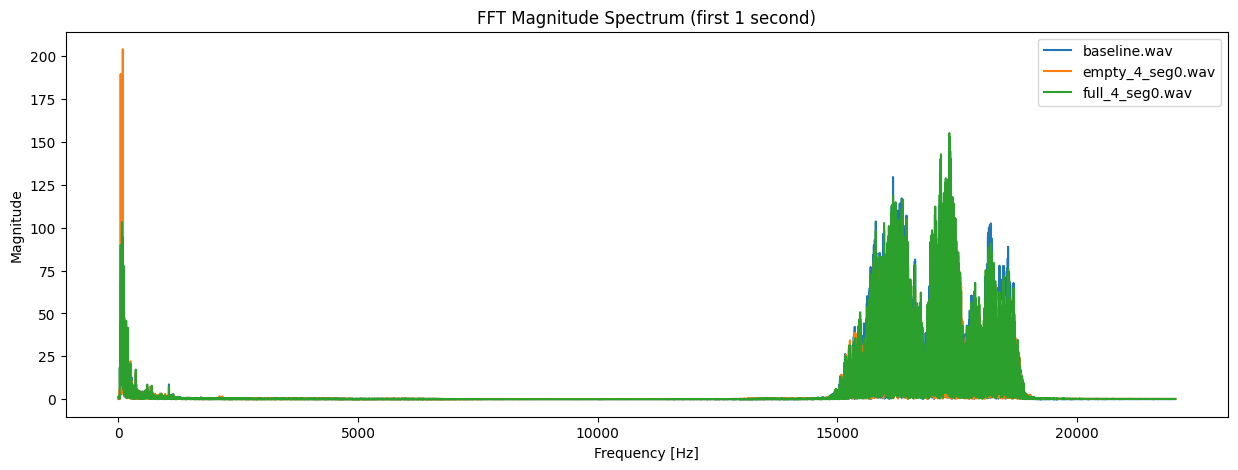

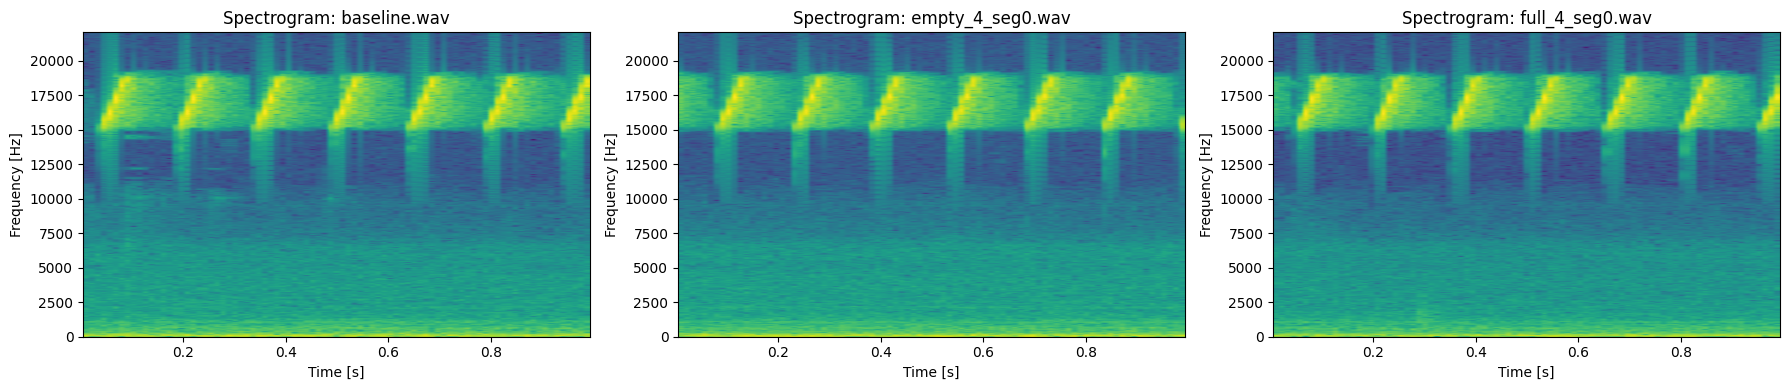

In [11]:
import torch
import torchaudio
import matplotlib.pyplot as plt

files = {
    "baseline.wav": "./baseline.wav",
    "empty_4_seg0.wav": "./recorded_audio/battery/test/empty_4_seg0.wav",
    "full_4_seg0.wav": "./recorded_audio/battery/test/full_4_seg0.wav"
}

plt.figure(figsize=(15, 5))

# --- FFT comparison ---
for name, path in files.items():
    waveform, sr = torchaudio.load(path)
    waveform = waveform[0, :sr]   # first channel, first 1 second

    # FFT
    fft_vals = torch.fft.fft(waveform)
    fft_freqs = torch.fft.fftfreq(waveform.size(0), 1/sr)

    # Plot magnitude spectrum (only positive freqs)
    plt.plot(fft_freqs[:len(fft_freqs)//2],
             fft_vals.abs()[:len(fft_vals)//2].numpy(),
             label=name)

plt.title("FFT Magnitude Spectrum (first 1 second)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

# --- Spectrograms ---
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
for ax, (name, path) in zip(axs, files.items()):
    waveform, sr = torchaudio.load(path)
    waveform = waveform[0, :sr]   # first channel, 1 second

    ax.specgram(waveform.numpy(), Fs=sr, NFFT=1024, noverlap=512)
    ax.set_title(f"Spectrogram: {name}")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Frequency [Hz]")

plt.tight_layout()
plt.show()


 ...]

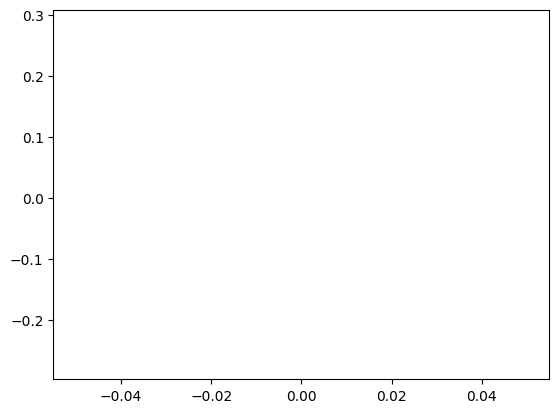

In [3]:
import torch
import torchaudio
import matplotlib.pyplot as plt

files = ["./baseline.wav", "./recorded_audio/battery/test/empty_4_seg0.wav", "./recorded_audio/battery/test/empty_3_seg0.wav"]
clr = ["r", "g", "b"]
waveform, sr = torchaudio.load(files[0])
max_len = 3 * sr
waveform = waveform[:, :max_len]
nf = waveform.shape[0]
tx = torch.arange(0, nf/sr)

plt.plot(tx.numpy(), waveform.numpy(),color=clr[0] ,label=f"{1}")

/Users/shamit/Documents/Projects/RA/cobas/cobas/venv/lib/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


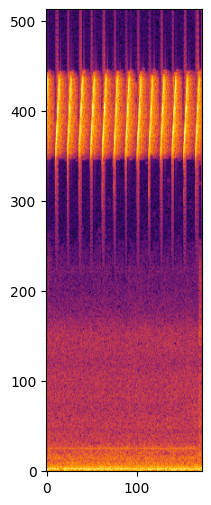

In [4]:
import torchaudio
import matplotlib.pyplot as plt
waveform, sr = torchaudio.load("./recorded_audio/battery/test/empty_3_seg0.wav")

specto = torchaudio.transforms.Spectrogram(
    n_fft=1024,
    win_length=None,
    hop_length=512,
    power=2.0
)
spec = specto(waveform)
spec_db = torchaudio.transforms.AmplitudeToDB()(spec)

plt.figure(figsize=(10,6))
plt.imshow(spec_db.squeeze().numpy(), origin="lower", cmap="inferno")
plt.show()